### Cotton Leaf Disease prediction Using Transfer Learning with VGG16 

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

### Re-size all the images

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'train'
valid_path = 'test'

In [3]:
train_path

'train'

#### Removing the last layer of VGG16 

In [4]:
#Add preprocessing layer to the front of VGG
# Here we will be using imagenet weights


vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
# Avoiding existing VGG16 layers from training as they are pretrained
for layer in vgg16.layers:
    layer.trainable = False

#### Getting number of categories 

In [6]:

# useful for getting number of output classes
folders = glob('train/*')

In [7]:
folders

['train\\diseased cotton leaf',
 'train\\diseased cotton plant',
 'train\\fresh cotton leaf',
 'train\\fresh cotton plant']

#### Flattening the last layers

In [8]:
x = Flatten()(vgg16.output)

### Creating a model object
 

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)#Appending output layer 

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Model Compilation

In [11]:
#Defining cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

#### Data Augmentation 

In [12]:

# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [14]:
len(training_set)

61

In [15]:
test_set = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 106 images belonging to 4 classes.


In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 4 steps
Epoch 1/5
61/61 [==============================] - 404s 7s/step - loss: 0.7283 - accuracy: 0.7294 - val_loss: 0.2957 - val_accuracy: 0.8774
Epoch 2/5
61/61 [==============================] - 396s 6s/step - loss: 0.2605 - accuracy: 0.9001 - val_loss: 0.1942 - val_accuracy: 0.9340
Epoch 3/5
61/61 [==============================] - 394s 6s/step - loss: 0.1868 - accuracy: 0.9339 - val_loss: 0.1792 - val_accuracy: 0.9151
Epoch 4/5
61/61 [==============================] - 398s 7s/step - loss: 0.1291 - accuracy: 0.9605 - val_loss: 0.1298 - val_accuracy: 0.9528
Epoch 5/5
61/61 [==============================] - 410s 7s/step - loss: 0.1127 - accuracy: 0.9657 - val_loss: 0.1120 - val_accuracy: 0.9434


### Plotting Accuracies and Loss for all epochs 

In [17]:
import matplotlib.pyplot as plt


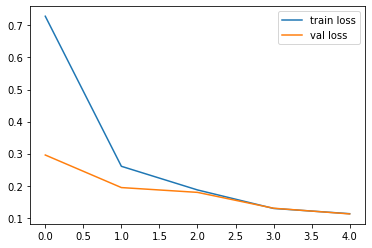

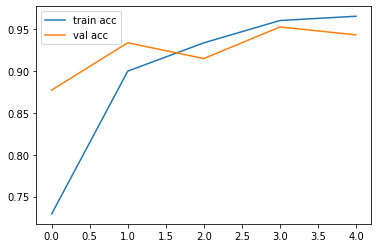

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [41]:
r.history['val_accuracy']

[0.23584905,
 0.2264151,
 0.28301886,
 0.254717,
 0.3018868,
 0.254717,
 0.23584905,
 0.23584905,
 0.2264151,
 0.23584905]

#### Model saving 

In [19]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('vgg16.h5')

### Prediction

In [20]:
y_pred = model.predict(test_set)


In [21]:
y_pred

array([[9.99935508e-01, 5.37242777e-05, 8.30307545e-06, 2.40491158e-06],
       [2.52311770e-03, 5.33357252e-07, 9.97476280e-01, 8.48791473e-08],
       [9.66869593e-01, 3.65608721e-03, 3.42799886e-03, 2.60464363e-02],
       [1.08790868e-04, 5.85322753e-02, 2.64336104e-05, 9.41332459e-01],
       [6.99686871e-06, 2.05225851e-02, 2.32101434e-06, 9.79468167e-01],
       [9.97486830e-01, 1.35508570e-04, 2.37453310e-03, 3.14293493e-06],
       [8.66846263e-01, 2.15498381e-04, 1.32909507e-01, 2.88036244e-05],
       [1.02668237e-04, 9.74367440e-01, 3.76418221e-08, 2.55298801e-02],
       [7.99159466e-07, 2.13392491e-06, 3.72336717e-06, 9.99993324e-01],
       [5.32163598e-04, 1.54973129e-02, 2.82171182e-03, 9.81148779e-01],
       [2.40550525e-02, 4.21109706e-01, 5.47977686e-01, 6.85764570e-03],
       [1.77342590e-04, 7.95002095e-03, 7.36466172e-05, 9.91798997e-01],
       [2.50184108e-02, 4.91741639e-06, 9.74969447e-01, 7.15091028e-06],
       [9.98258173e-01, 1.24841894e-03, 5.77954634e

In [22]:
import numpy as np
y_pred1 = np.argmax(y_pred, axis=1)

In [23]:
y_pred1

array([0, 2, 0, 3, 3, 0, 0, 1, 3, 3, 2, 3, 2, 0, 3, 2, 2, 3, 3, 1, 3, 0,
       2, 3, 1, 1, 1, 3, 3, 3, 1, 2, 3, 2, 3, 3, 0, 1, 1, 3, 1, 1, 3, 3,
       2, 2, 0, 1, 2, 0, 2, 3, 1, 2, 3, 1, 0, 1, 2, 3, 2, 2, 1, 0, 2, 1,
       0, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 3, 3, 1, 3, 0, 0, 2, 2, 1, 1, 0,
       0, 1, 2, 1, 0, 0, 2, 0, 2, 3, 0, 0, 1, 0, 1, 1, 2, 1], dtype=int64)

In [24]:
test_set.classes


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [53]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('C:/Users/anjit/Machine Learning/deep learning/Cotton Disease/test/fresh cotton plant/dsd (140)_iaip.jpg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

In [54]:
result

array([[2.6731404e-05, 1.4880022e-02, 3.9089654e-04, 9.8470229e-01]],
      dtype=float32)

In [55]:
a= np.argmax(model.predict(test_image),axis=1)


In [56]:
a

array([3], dtype=int64)

In [57]:
if a==0:
    print("diseased cotton leaf")
if a==1:
    print("diseased cotton plant")
if a==2:
    print("fresh cotton leaf")
if a==3:
    print("fresh cotton plant")

fresh cotton plant
